In [2]:
import pandas as pd
import pylab as plt
import seaborn
import numpy as np
import re
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
%pylab inline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

Populating the interactive namespace from numpy and matplotlib


### Реализация алгоритма F4 с нормальной стратегией выбора S-пар и стратегией просто выбора всех пар.

In [3]:
#  Implementation of the F4 Algorithm in Sage
#  [1]  Jean-Charles Faugere. A new efficient algorithm for computing Groebner bases (F4). Journal of pure and applied algebra, 139(1–3):61–88, July 1999.
#  [2]  Alessandro Giovini, Teo Mora, Gianfranco Niesi, Lorenzo Robbiano, Carlo Traverso. "One sugar cube, please "or Selection strategies in the Buchberger algorithm"".

########################################
#  Create a pair from two polynomials  #
########################################
#  [1] Definition 2.5, page 5

def Pair(f, g):
    try:
        lcm = (f.lm()).lcm(g.lm())
        return (lcm, lcm // f.lm(), f, lcm // g.lm(), g)
    except ZeroDivisionError:
        raise Exception()

########################################
#   Function adds new pairs to Pairs (f, g) where f belongs to new (set of polynomials),
#   g belongs to basis (temporary basis Gr. already found up to this point)
########################################

def FirstBuchbergerCriterion(f, g):
    if (f.lm()).gcd(g.lm()) == 1:
        return True
    return False

'''
def SecondBuchbergerCriterion(f, g, basis, pairs):
    isReducible, h = IsTopReducible((f.lm()).lcm(g.lm()), basis)
    if isReducible:
        if Pair(f, h) in pairs and Pair(g, h) in pairs:
            return True
    return False

def BuchbergerCriteria(f, g, basis, Pairs):
    if FirstBuchbergerCriterion(f, g) and SecondBuchbergerCriterion(f, g, basis, pairs):
        return True
    return False
'''

def Update(basis, pairs, new):
    try:
        basis += new
        basis = uniq(basis)
        for f in new:
            for g in basis:
                if f != g and Pair(g, f) not in pairs:
                    if not FirstBuchbergerCriterion(f, g):
                        pairs.append(Pair(f, g))
        result = [basis, pairs]
        return result
    except Exception:
        print "basis = ", basis
        for elem in basis:
            print elem.parent()

##############################################
#  Selection function - the normal strategy  #
##############################################
#  [1] function Sel, page 13

def LCM(pair):
    return pair[0]

def SelectionFunctionNormal(pairs):
    d = min([LCM(p).degree() for p in pairs])
    dPairs = [p for p in pairs if LCM(p).degree() == d]
    return dPairs

##############################################
#  Selection function - take all pairs  #
##############################################

def SelectionFunctionAll(pairs):
    return pairs

############################
#  Symbolic Preprocessing  #
############################
#  [1] Symbolic Preprocessing, page 7
#  for this procedure better see http://www.broune.com/papers/f4.pdf
#  page 2, instead of the original paper

def IsTopReducible(f, G):
    m = f.lm()
    for g in G:
        if g.lm().divides(m):
             return True, g
    return False, 0

def SymbolicPreprocessing(L, G):
    F = []
    for Li in L:
        F.append(Li[0] * Li[1])
    done = set([f.lt() for f in F])
    TF = set()
    for f in F:
        TF |= set(f.monomials())

    while len(TF) > 0:
        m = TF.pop()
        done.add(m)
        isReducible, f = IsTopReducible(m, G)
        if isReducible:
            mDash = m // f.lm()
            F.append(mDash * f)
            newMonomials = (mDash * f).monomials()
            newMonomials.remove(newMonomials[0])
            TF |= set(newMonomials)
            TF -= done
    return F

###############
#  Reduction  #
###############
#  [1] Reduction, page 6

def Reduction(L, G):
    F = SymbolicPreprocessing(L, G)

    leadingMonomials = set()
    for f in F:
        leadingMonomials.add(f.lm())

    monomials = set()
    for f in F:
        monomials |= set(f.monomials())

    monomials = list(monomials)
    monomials.sort(reverse = True)

    M = Matrix(len(F), len(monomials), lambda i, j: F[i].monomial_coefficient(monomials[j]), sparse = True)
    M.echelonize()
    polynomialsAfterEchelonize = []

    for i in range(M.nrows()):
        f = 0
        for j in range(M.ncols()):
            f += M[i, j] * monomials[j]
        if f != 0 and f.lm() not in leadingMonomials:
            polynomialsAfterEchelonize.append(f)

    return polynomialsAfterEchelonize

def IsReducible(f, F):
    if F == []:
        return False, 0
    f1 = f.reduce(F)
    if f1 != f:
        return True, f1
    return False, 0

def ReductionOfBasis(F):
    i = 0
    while i < len(F):
        if F[i] != 0:
            G = []
            for j in range (len(F)):
                if j != i:
                    if F[j] != 0:
                        G.append(F[j])
            (t, g) = IsReducible(F[i], G)
            if t:
                F[i] = g
                i = -1
        i += 1
    G = []
    for j in range (len(F)):
        if F[j] != 0:
            G.append(F[j] / F[j].lc())
    return G

#######################################
#  Main function of the F4 Algorithm  #
#######################################
#  [1] Algorithm F4, page 6

def F4(polynomials, strategy):
    (basis, pairs) = Update([], [], polynomials)
    howManySteps = 0

    while len(pairs) > 0:
        howManySteps += 1

        if (strategy == 'normal'):
            pairsSel = SelectionFunctionNormal(pairs)
        else:
            pairsSel = SelectionFunctionAll(pairs)
        pairs = list(set(pairs) - set(pairsSel))

        Ld = set()
        for pair in pairsSel:
            Ld.add((pair[1], pair[2]))
            Ld.add((pair[3], pair[4]))

        new = Reduction(Ld, basis)
        (basis, pairs) = Update(basis, pairs, new)

    return ReductionOfBasis(basis), howManySteps

print "\n\nEXAMPLE 1\n"
R.<x, y, z, u> = PolynomialRing(QQ, 4, order = "degrevlex")
F = [x + y + z, x * y + x * z + y * z, x * y * z - u ^ 3]
print "The initial system F =", F
print "\nOutput of F4:"
print F4(F, 'normal')
print F4(F, 'all')

print "\n\nEXAMPLE 2\n"
f = x*y - z^2 - z
g = x^2 - x - y*z
h = x*z - y^2 - y
F = [f, g, h]
print "The initial system F =", F
print "\nOutput of F4:"
print F4(F, 'normal')
print F4(F, 'all')

print "\n\nEXAMPLE 3\n"
R.<x1, x2, x3, x4> = PolynomialRing(QQ, 4)
F = [4*x4, -2*x2^2 - 4*x1*x3 + 6*x4^2, 4*x1^2*x2 + 4*x2*x3^2 - 4*x2^2*x4 - 8*x1*x3*x4 + 4*x4^3, -x1^4 + x2^4 - 4*x1*x2^2*x3 + 2*x1^2*x3^2 - x3^4 + 4*x1^2*x2*x4 + 4*x2*x3^2*x4 - 2*x2^2*x4^2 - 4*x1*x3*x4^2 + x4^4]
print "The initial system F =", F
print "\nOutput of F4:"
print F4(F, 'normal')
print F4(F, 'all')



EXAMPLE 1

The initial system F = [x + y + z, x*y + x*z + y*z, x*y*z - u^3]

Output of F4:
([x + y + z, y^2 + y*z + z^2, z^3 - u^3], 4)
([x + y + z, y^2 + y*z + z^2, z^3 - u^3], 2)


EXAMPLE 2

The initial system F = [x*y - z^2 - z, x^2 - y*z - x, -y^2 + x*z - y]

Output of F4:
([y*z, x*z - z^2 - z, y^2 - z^2 + y - z, x*y - z^2 - z, x^2 - x, z^3 + z^2], 3)
([y*z, x*z - z^2 - z, y^2 - z^2 + y - z, x*y - z^2 - z, x^2 - x, z^3 + z^2], 3)


EXAMPLE 3

The initial system F = [4*x4, -2*x2^2 - 4*x1*x3 + 6*x4^2, 4*x1^2*x2 + 4*x2*x3^2 - 4*x2^2*x4 - 8*x1*x3*x4 + 4*x4^3, -x1^4 + x2^4 - 4*x1*x2^2*x3 + 2*x1^2*x3^2 - x3^4 + 4*x1^2*x2*x4 + 4*x2*x3^2*x4 - 2*x2^2*x4^2 - 4*x1*x3*x4^2 + x4^4]

Output of F4:


([x4, x2^2 + 2*x1*x3, x1^2*x2 + x2*x3^2, x1^3*x3 + x1*x3^3, x1^4 - 14*x1^2*x3^2 + x3^4, x2*x3^4, x1^2*x3^3 - 1/15*x3^5, x1*x3^5, x3^7], 7)
([x4, x2^2 + 2*x1*x3, x1^2*x2 + x2*x3^2, x1^3*x3 + x1*x3^3, x1^4 - 14*x1^2*x3^2 + x3^4, x2*x3^4, x1^2*x3^3 - 1/15*x3^5, x1*x3^5, x3^7], 4)


In [4]:
def Spol(f, g):
    h = (f.lm()).lcm(g.lm())
    return g.lc() * h * f // f.lm() - f.lc() * h * g // g.lm()

def is_groebner_basis(G):
    if G == []:
        return False
    R = G[0].parent()
    for i in xrange(len(G)) :
        f = G[i]
        for j in xrange(i, len(G)) :
            g = G[j]
            if (Spol(f, g)).reduce(G) != R(0) :
                return False
    return True

def LaunchF4(n):
    for i in range (n):
        generators = GetRandomGeneratorsForIdeal(4, 4, 4)
        while 0 in generators:
            print "Zero in generators"
            generators = GetRandomGeneratorsForIdeal(4, 4, 4)
        basis, steps = F4(generators, 'all')
        if not is_groebner_basis(basis):
            print "error, system = ", generators

# %time LaunchF4(200)

Займёмся теперь тем, что сгенерируем данные для выбора более хорошей стратегии. Будем сравнивать стратегии normal и all (реализованы в алгоритме). Пока будем считать, что стратегия хорошая, если 

Пока что мы будем считать, что стратегия хороша, если при её использовании было сделано меньше итераций алгоритма. Под итерацией понимается итерация основного цикла while len(pairs > 0) в функции F4(polynomials, strategy). Число итераций -- это число приведений к ступенчатому виду матриц, возникающих в процессе алгоритма, так как матрица строится только при вызове Reduction, а она вызывается как раз в этом цикле.

У нас будут следущие признаки для каждого идела:

1. Число переменных в кольце-родителе.
2. Число порождающих в идеале.
3. Максимальная длина порождающего полинома (длина := число мономов).
4. Минимальная длина порождающего полинома.
5. Максимальная степень порождающего (полная, то есть наибольшая степень входящего в него монома).
6. Минимальная степень порождающего.
7. Однородный ли идеал.

Так как однородные идеалы при случайной генерации не встречаются почти никогда, я вставила в генерирующую функцию условие, при котором она должна будет сделать идеал однородным (см. код функции GetRandomGeneratorsForIdeal). Функция GenerateDataSet генерирует датасет. Принимает на вход количество объектов в генерируемых данных, ограничение сверху на на число переменных в кольце-родителе, число порождающих и максимальную степень порождающих.

In [52]:
def Print(numOfObjects, i):
    if numOfObjects <= 30:
        print "Object No: ", i
    elif numOfObjects <= 100 and i % 10 == 0:
        print "Object No: ", i
    elif numOfObjects <= 3000 and i % 50 == 0:
        print "Object No: ", i
    elif numOfObjects <= 6000 and i % 100 == 0:
        print "Object No: ", i

def GetFeatures(generators):
    features = {}
    R = generators[0].parent()
    features["number of variables"] = R.ngens()
    features["number of generators"] = len(generators)
    features["max number of monomials"] = max([len(p.monomials()) for p in generators])
    features["min number of monomials"] = min([len(p.monomials()) for p in generators])
    features["max degree of generators"] = max([f.degree() for f in generators])
    features["min degree of generators"] = min([f.degree() for f in generators])
    features["ideal is homogeneous"] = int(R.ideal(generators).is_homogeneous())
    return features

def GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar = 1, minElem = 2,  minDeg = 1):
    nVar = np.random.randint(minVar, maxVar)
    nElem = np.random.randint(minElem, maxElem)

    R = PolynomialRing(QQ, 'x', nVar)
    generators = []

    if nVar + nElem % 2 == 1:
        R = (R.gens()[0] + 1).homogenize().parent()     # if we apply .homognize() to a homogeneous polynomial it's parent ring won't change
                                                        # but we want to have a unique parent for all generators
    for i in range(nElem):
        deg = np.random.randint(minDeg, maxDeg)
        randomPol = R.random_element(degree = deg)

        while randomPol == R(0):

            randomPol = R.random_element(degree = deg)

        if nVar + nElem % 2 == 1:    # just a random criteria for a homogeneous ideal to appear
            generators.append(R(randomPol.homogenize()))
        else:
            generators.append(randomPol)
    return generators

def MakeDataSet(allFeatures):
    indices = [i for i in range(len(allFeatures))]
    data = {}
    for key in allFeatures[0].keys():
        data[key] = pd.Series([f[key] for f in allFeatures], index = indices)

    df = pd.DataFrame(data)
    return df

def GenerateDataSet(numOfObjects, maxVar, maxElem, maxDeg, minVar = 1, minElem = 2,  minDeg = 1):
    allFeatures = []
    whichStrategyIsBetter = []

    for i in range (numOfObjects):
        Print(numOfObjects, i)

        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)
        while 0 in generators:
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)

        features = GetFeatures(generators)

        basis, howManyStepsN = F4(generators, 'normal')
        basis, howManyStepsAll = F4(generators, 'all')

        if howManyStepsN <= howManyStepsAll:
            features['better strategy: 1 - normal, 0 - all'] = 1
        else:
            features['better strategy: 1 - normal, 0 - all'] = 0

        allFeatures.append(features)

    return MakeDataSet(allFeatures)

Сгенерируем датасет со случайными полиномами с коэффициентами из Q, у которых число переменных, порождающих в идеале и степень каждого из порождающих не превышает 4 (имеется в виду полная степень). Объектов у нас будет 5000.

In [53]:
%time df = GenerateDataSet(5000, 4, 4, 4)

Object No:  0


Object No:  100


Object No:  200


Object No:  300


Object No:  400


Object No:  500


Object No:  600


Object No:  700


Object No:  800


Object No:  900


Object No:  1000


Object No:  1100


Object No:  1200


Object No:  1300


Object No:  1400


Object No:  1500


Object No:  1600


Object No:  1700


Object No:  1800


Object No:  1900


Object No:  2000


Object No:  2100


Object No:  2200


Object No:  2300


Object No:  2400


Object No:  2500


Object No:  2600


Object No:  2700


Object No:  2800


Object No:  2900


Object No:  3000


Object No:  3100


Object No:  3200


Object No:  3300


Object No:  3400


Object No:  3500


Object No:  3600


Object No:  3700


Object No:  3800


Object No:  3900


Object No:  4000


Object No:  4100


Object No:  4200


Object No:  4300


Object No:  4400


Object No:  4500


Object No:  4600


Object No:  4700


Object No:  4800


Object No:  4900


CPU times: user 3min 28s, sys: 2.27 s, total: 3min 30s
Wall time: 3min 47s


In [54]:
df.head()

,"better strategy: 1 - normal, 0 - all",ideal is homogeneous,max degree of generators,max number of monomials,min degree of generators,min number of monomials,number of generators,number of variables
0,1,1,2,2,1,1,2,2
1,1,1,3,3,2,2,2,2
2,1,0,2,4,1,3,3,2
3,1,0,3,4,1,1,3,2
4,0,0,3,4,2,3,3,3


In [56]:
df['better strategy: 1 - normal, 0 - all'] = np.where(df['better strategy: 1 - normal, 0 - all'] == 1, 1, 0)
y = df['better strategy: 1 - normal, 0 - all'] #выделили в отдельную переменную
X = df.drop('better strategy: 1 - normal, 0 - all', axis = 1)
X.head()

,ideal is homogeneous,max degree of generators,max number of monomials,min degree of generators,min number of monomials,number of generators,number of variables
0,1,2,2,1,1,2,2
1,1,3,3,2,2,2,2
2,0,2,4,1,3,3,2
3,0,3,4,1,1,3,2
4,0,3,4,2,3,3,3


Разделим нашу выборку на обучающую и тестовую.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [58]:
X_train.head()

,ideal is homogeneous,max degree of generators,max number of monomials,min degree of generators,min number of monomials,number of generators,number of variables
4884,0,3,4,1,3,3,3
3163,0,3,5,1,3,2,2
490,0,3,5,1,2,3,2
862,1,2,3,1,2,2,2
1740,1,1,2,1,1,2,2


Обучим на SVM-классификатор с RBF-ядром. Параметры пока оставим по умолчанию.

In [59]:
clf = SVC(kernel = 'rbf')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Попросим классификатор что-нибудь предсказать.

In [60]:
pred_svm = clf.predict(X_test)
pred_svm[ : 10]

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0])

Посмотрим, насколько точно наш классификатор выдаёт ответы. Сделаем это с помощью следующих трёх метрик:
- accuracy: $$ Accuracy = \frac{1}{l}\sum_{i=1}^l[y_i = \hat{y}_i]$$ где $y_i$ — истинный ответ на объекте $x_i$, $\hat{y}_i$ — предсказанный. (лучше не переводить *accuracy* как точность, потому что в русскоязычной литературе точностью называют другую метрику)
- точность: $$Precision = \frac{TP}{TP + FP}$$
- полнота: $$Recall = \frac{TP}{TP + FN}$$

где обозначения *TP*, *FP*, *FN* и *TN* — элементы матрицы ошибок:

| | y = 1 | y = 0 |
|------|------|
|   a(x) = 1  | TP| FP |
| a(x) = 0| FN | TN |

Точность и полнота вычисляются относительно фиксированного класса. Получается, что accuracy -- это просто доля верно предсказанных ответов. Точность -- это доля верно отнесённых к рассматриваему классу объектов. Полнота -- насколько хорошо мы предсказываем объекты данного класса (ведь FN = false negative -- пропущенный объект рассматриваемого класса). Измерим все эти три метрики.

In [61]:
print "accuracy = ", metrics.accuracy_score(y_test, pred_svm)

accuracy =  0.8488


In [62]:
target_names = ['class all', 'class normal']

print classification_report(y_test, pred_svm, target_names = target_names)

              precision    recall  f1-score   support

   class all       0.76      0.74      0.75       383
class normal       0.89      0.90      0.89       867

 avg / total       0.85      0.85      0.85      1250



Получается, что в 86% случаев ответ классификатора верный (по метрике accuracy). Кажется, что это довольно неплохо.

Видно, что показатели precision оба довольно высоки, а показатель recall для класса normal похуже. Оно и понятно, ведь, как ни странно, стратегия "взять все S-полиномы" часто оказывается лучше нормальной, то есть класс all встречается чаще. Хотя это только по числу шагов, стоит измерить и по другим параметрам.

Измерим качество предсказаний с помощью ещё двух метрик качества: площадями под ROC-кривой и Recall-кривой.

### Precision-Recall кривая

Раз мы умеем варьировать порог классификатора, тем самым меняя качество, интересно каким оно будет при всех возможных различных порогах. Для этого обычно строят следующий график: перебирают все пороги и по оси ОХ откладывают полноту получившегося классификатора, а по оси OY — точность. Таким образом, это дает хорошую наглядную визуализацию качества алгоритма.

### ROC кривая

Еще один из способ визуализации зависимости метрик качества от порога, подходящей в этом случае, является *ROC*. По осям: 
 - OX: $FPR = \frac{FP}{FP + TN}$
 - OY: $TPR = \frac{TP}{TP + FN}$

Кроме того, можно измерять площади под указанными кривыми — *auc_pr* и *auc_roc* соответственно.

Нарисуем эти кривые для нашего случая и вычислим площади под ними.

In [63]:
clf = SVC(kernel = 'rbf', probability = True)
clf.fit(X_train, y_train)
predprob_svm = clf.predict_proba(X_test)
predprob_svm[ : 10]

array([[ 0.01307037,  0.98692963],
       [ 0.10175857,  0.89824143],
       [ 0.91675792,  0.08324208],
       [ 0.42816635,  0.57183365],
       [ 0.02521897,  0.97478103],
       [ 0.05117068,  0.94882932],
       [ 0.01004001,  0.98995999],
       [ 0.01682606,  0.98317394],
       [ 0.01363195,  0.98636805],
       [ 0.82406167,  0.17593833]])

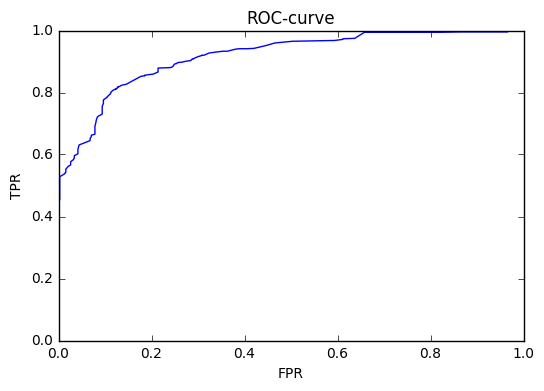

In [64]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predprob_svm[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC-curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [65]:
print 'AUC-ROC:', metrics.auc(fpr, tpr)

AUC-ROC: 0.916565028715


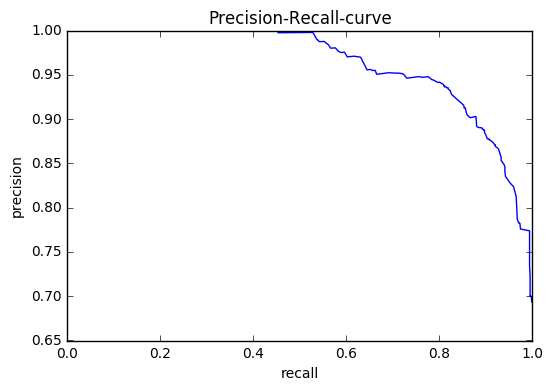

In [66]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, predprob_svm[:, 1])
plt.plot(recall, precision)
plt.title('Precision-Recall-curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [67]:
print "AUC-PR: ", metrics.auc(recall, precision)

AUC-PR:  0.963040902665


Видно, что показатели AUC-ROC и AUC-PR довольно хороши. 

Попробуем узнать, какие признаки являются самыми информативными с помощью случайного леса.

In [68]:
def GetFeatureImportances(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

    clf = RandomForestClassifier(n_estimators = 200, n_jobs=-1, random_state = 42)
    clf = clf.fit(X_train, y_train)

    importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,3)})
    importances = importances.sort_values('importance',ascending=False).set_index('feature')
    print importances
    importances.plot.bar()

                          importance
feature                             
number of generators           0.307
max degree of generators       0.280
min degree of generators       0.196
number of variables            0.072
min number of monomials        0.070
max number of monomials        0.059
ideal is homogeneous           0.017


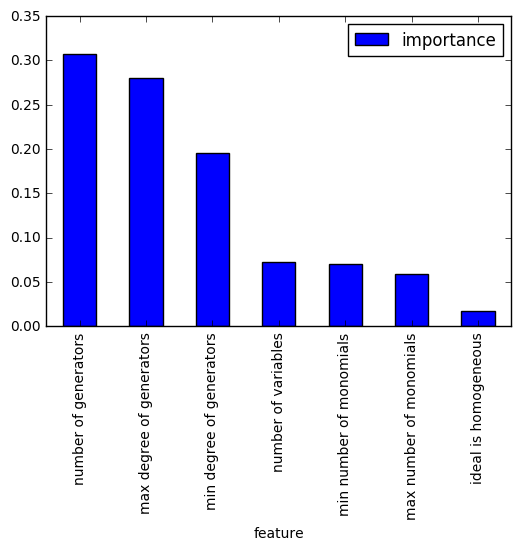

In [69]:
GetFeatureImportances(X, y)

### Сравнение стратегий с точки зрения времени

Сравним стратегии с точки зрения времени.

In [70]:
from time import time

def LaunchF4_time(n):
    times = []
    better_strategy = []
    for i in range (n):
        Print(n, i)
        times.append([])
        generators = GetRandomGeneratorsForIdeal(4, 4, 4)
        while 0 in generators:
            # print "Zero in generators"
            generators = GetRandomGeneratorsForIdeal(4, 4, 4)

        t1 = time()
        F4(generators, 'normal')
        t1 = time() - t1
        times[i].append(t1)

        t2 = time()
        F4(generators, 'all')
        t2 = time() - t2
        times[i].append(t2)

        if t2 > t1:
            better_strategy.append(1)
        else:
            better_strategy.append(0)

    indices = [i for i in range(n)]

    d = {
    'time with normal' : pd.Series([t[0] for t in times], index = indices),
    'time with all': pd.Series([t[1] for t in times], index = indices),
    'better strategy: 1 - normal, 0 - all' : pd.Series(better_strategy, index = indices)
    }
    return pd.DataFrame(d)

In [71]:
%time df_time = LaunchF4_time(1000)

Object No:  0


Object No:  50


Object No:  100


Object No:  150


Object No:  200


Object No:  250


Object No:  300


Object No:  350


Object No:  400


Object No:  450


Object No:  500


Object No:  550


Object No:  600


Object No:  650


Object No:  700


Object No:  750


Object No:  800


Object No:  850


Object No:  900


Object No:  950


CPU times: user 30.7 s, sys: 442 ms, total: 31.1 s
Wall time: 35 s


In [72]:
df_time.head()

,"better strategy: 1 - normal, 0 - all",time with all,time with normal
0,0,0.002375,0.005603
1,1,0.015063,0.005647
2,0,0.000102,0.000143
3,0,0.000120,0.000162
4,0,0.001682,0.003196


In [73]:
df_time['better strategy: 1 - normal, 0 - all'].value_counts()

0    810
1    190
Name: better strategy: 1 - normal, 0 - all, dtype: int64

При ограничении сверху четвёркой на число переменных, порождающих в идеале и степень каждого из порождающих стратегия all оказывается очень выигрышной по времени, как видно из подсчёта выше. К сожалению, при поднятии этих показателей вычисления становятся очень долгими или же приостанавливаются Ipython Notebook по каким-то причинам. Также пока не удаётся измерить затрачиваемую память.

Сгенерируем датасет ещё раз, но теперь более хорошей будет считаться та стратегия, с помощью которой было затрачено меньше времени на вычисления.

In [74]:
from time import time

def GenerateDataSetTime(numOfObjects, maxVar, maxElem, maxDeg, minVar = 1, minElem = 2,  minDeg = 1):
    allFeatures = []
    whichStrategyIsBetter = []

    for i in range (numOfObjects):
        Print(numOfObjects, i)

        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)
        while 0 in generators:
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)

        features = GetFeatures(generators)

        tNormal = time()
        basis, howManyStepsN = F4(generators, 'normal')
        tNormal = time() - tNormal

        tAll = time()
        basis, howManyStepsAll = F4(generators, 'all')
        tAll = time() - tAll

        if tNormal <= tAll:
            features['better strategy: 1 - normal, 0 - all'] = 1
        else:
            features['better strategy: 1 - normal, 0 - all'] = 0

        allFeatures.append(features)

    return MakeDataSet(allFeatures)

In [75]:
%time df = GenerateDataSetTime(5000, 4, 4, 4)

Object No:  0


Object No:  100


Object No:  200


Object No:  300


Object No:  400


Object No:  500


Object No:  600


Object No:  700


Object No:  800


Object No:  900


Object No:  1000


Object No:  1100


Object No:  1200


Object No:  1300


Object No:  1400


Object No:  1500


Object No:  1600


Object No:  1700


Object No:  1800


Object No:  1900


Object No:  2000


Object No:  2100


Object No:  2200


Object No:  2300


Object No:  2400


Object No:  2500


Object No:  2600


Object No:  2700


Object No:  2800


Object No:  2900


Object No:  3000


Object No:  3100


Object No:  3200


Object No:  3300


Object No:  3400


Object No:  3500


Object No:  3600


Object No:  3700


Object No:  3800


Object No:  3900


Object No:  4000


Object No:  4100


Object No:  4200


Object No:  4300


Object No:  4400


Object No:  4500


Object No:  4600


Object No:  4700


Object No:  4800


Object No:  4900


CPU times: user 2min 45s, sys: 2.14 s, total: 2min 47s
Wall time: 3min 1s


In [76]:
df['better strategy: 1 - normal, 0 - all'] = np.where(df['better strategy: 1 - normal, 0 - all'] == 1, 1, 0)
y = df['better strategy: 1 - normal, 0 - all'] #выделили в отдельную переменную
X = df.drop('better strategy: 1 - normal, 0 - all', axis = 1)
X.head()

,ideal is homogeneous,max degree of generators,max number of monomials,min degree of generators,min number of monomials,number of generators,number of variables
0,0,3,4,2,3,3,1
1,1,3,3,2,3,2,2
2,0,3,4,2,3,2,3
3,1,3,3,1,2,2,2
4,0,3,5,1,2,2,3


Посмотрим на те же метрики, что были рассмотрены при сравнении стратегий по числу шагов.

In [77]:
def TrainAndShowMetrics(X, y, classOne, classTwo, clf, transform = False):
    print "Classifier:\n"
    print clf
    print "\n"
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

    if transform:
        print "After StandardScaler\n"
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        clf.fit(X_train, y_train)
        X_test = scaler.transform(X_test)
        pred = clf.predict(X_test)

    else:
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

    print "accuracy = {} \n".format(metrics.accuracy_score(y_test, pred))

    target_names = [classOne, classTwo]

    print classification_report(y_test, pred, target_names = target_names)

    predprob = clf.predict_proba(X_test)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, predprob[:, 1])
    plt.plot(fpr, tpr)
    plt.title('ROC-curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

    print 'AUC-ROC:', metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(y_test, predprob[:, 1])
    plt.plot(recall, precision)
    plt.title('Precision-Recall-curve')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.show()

    print "AUC-PR: ", metrics.auc(recall, precision)


Classifier:

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)




accuracy = 0.8616 

              precision    recall  f1-score   support

   class all       0.88      0.96      0.92      1049
class normal       0.62      0.35      0.45       201

 avg / total       0.84      0.86      0.84      1250



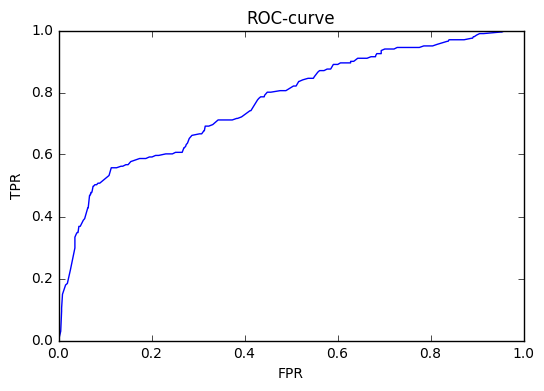

AUC-ROC: 0.769481951539


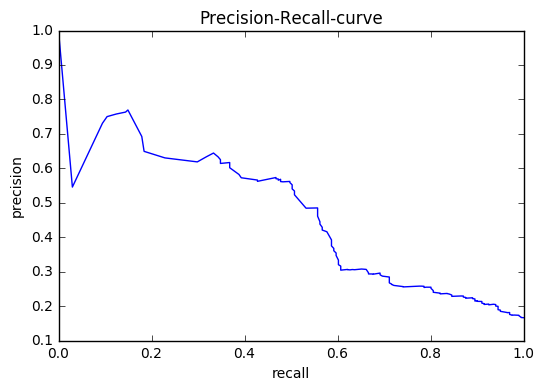

AUC-PR:  0.466270390342


In [78]:
clf = SVC(kernel = 'rbf', probability = True)

TrainAndShowMetrics(X, y, 'class all', 'class normal', clf)

Показатели плохи. Видимо, недостаточно имеющихся признаков для классификации по времени. Интересно, изменилась ли градация важности признаков при сравнении стратегий по другому параметру (то есть не по числу итераций, а по времени).

                          importance
feature                             
number of variables            0.305
number of generators           0.261
min number of monomials        0.141
max degree of generators       0.110
max number of monomials        0.087
min degree of generators       0.087
ideal is homogeneous           0.010


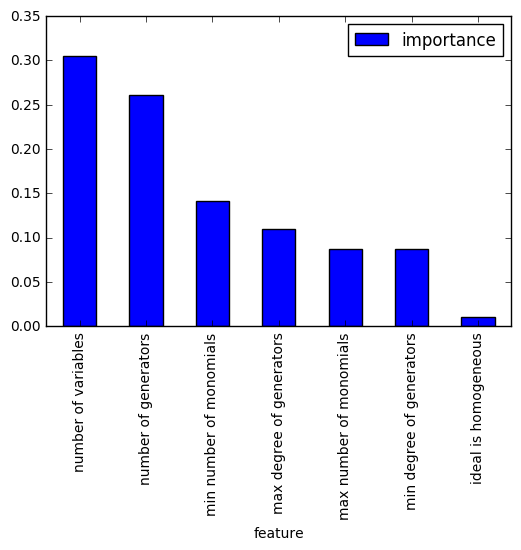

In [79]:
GetFeatureImportances(X, y)

Информативность признаков в целом понизилась, и наиболее информативными оказались не те признаки, что были для итераций. Довольно странно.

### Стратегия, основанная на машинном обучении 

##### Датасет и выбор классификатора

Попробуем научиться выбирать S-пары, основываясь на машинном обучении. Будем считать S-пару хорошей, если она не редуцируется относительно текущего базиса к нулю, и плохой в противном случае. Для sPair(f, g) будем называть левым и правым полиномы f и g соответственно. Признаки у S-пары f и g будут состоять из признаков для обоих полиномов и признаков текущего базиса Грёбнера:
1. Степень НОК(f.lm(), g.lm())

(каждый следующий признак берётся и для левого, и для правого полиномов)

2. Степень полинома (полная).
3. Степень старшего монома.
4. Количество мономов.
5. Количество переменных.
6. Максимальная степень по переменной.
7. Минимальная степень по переменной.

(следующие признаки берутся для идеала, порождённого текущим базисом)

8. Число переменных в кольце-родителе.
9. Число порождающих в идеале.
10. Максимальная длина порождающего полинома (длина := число мономов).
11. Минимальная длина порождающего полинома.
12. Максимальная степень порождающего (полная, то есть наибольшая степень входящего в него монома).
13. Минимальная степень порождающего.

Всего признаков вышло 19. Для датасета будем запускать F4 до тех пор, пока суммарно за все запуски не будет рассмотрено количество S-пар не меньше некоторого заданного.

In [8]:
def GetMaxDegreeByVariable(polynomials, variable):
    maxDegVar = max([pol.degree(variable) for pol in polynomials])

def GetIdealFeatures(generators, featureVector):
    R = generators[0].parent()
    featureVector["number of variables in parent ring"] = R.ngens()
    featureVector["number of generators"] = len(generators)
    featureVector["max number of monomials in generators"] = max([len(p.monomials()) for p in generators])
    featureVector["min number of monomials in generators"] = min([len(p.monomials()) for p in generators])
    featureVector["max degree of generators"] = max([f.degree() for f in generators])
    featureVector["min degree of generators"] = min([f.degree() for f in generators])

def GetPolynomialFeatures(polynomial, polynomialName, featureVector):
    R = polynomial.parent()
    X = R.gens()
    featureVector["number of variables for " + polynomialName] = R.ngens()
    featureVector["number of monomials for " + polynomialName] = len(polynomial.monomials())
    featureVector["min degree by variable for " + polynomialName] = min([polynomial.degree(variable) for variable in X])
    featureVector["max degree by variable for " + polynomialName] = max([polynomial.degree(variable) for variable in X])
    featureVector["full degree for " + polynomialName] = polynomial.degree()
    featureVector["lt degree for " + polynomialName] = polynomial.lt().degree()

def GetPairFeatures(pair, basis, featureVector):
    leftPolynomial, rightPolynomial = pair[2], pair[4]
    leftX = leftPolynomial.parent().gens()
    rightX = rightPolynomial.parent().gens()

    featureVector["lcm degree"] = pair[0].degree()
    GetIdealFeatures(basis, featureVector)
    GetPolynomialFeatures(leftPolynomial, "left polynomial", featureVector)
    GetPolynomialFeatures(rightPolynomial, "right polynomial", featureVector)

def Spol(f, g):
    h = (f.lm()).lcm(g.lm())
    return g.lc() * h * f // f.lm() - f.lc() * h * g // g.lm()

def GetData(pairs, basis, allFeatures):
    for pair in pairs:
        featureVector = {}
        GetPairFeatures(pair, basis, featureVector)
        if Spol(pair[2], pair[4]).reduce(basis) == 0:
            featureVector["should be taken"] = 0
        else:
            featureVector["should be taken"] = 1
        allFeatures.append(featureVector)

def F4_data(polynomials, allFeatures):
    (basis, pairs) = Update([], [], polynomials)

    while len(pairs) > 0:
        pairsSel = SelectionFunctionAll(pairs)
        GetData(pairs, basis, allFeatures)

        pairs = list(set(pairs) - set(pairsSel))

        Ld = set()
        for pair in pairsSel:
            Ld.add((pair[1], pair[2]))
            Ld.add((pair[3], pair[4]))

        Fdtplus = Reduction(Ld, basis)
        (basis, pairs) = Update(basis, pairs, Fdtplus)

    return ReductionOfBasis(basis)

def CreateDataSetForNewStrategy(approximateNumOfObjects, maxVar, maxElem, maxDeg, minVar = 1, minElem = 2,  minDeg = 1):
    allFeatures = []
    counter = 0
    while len(allFeatures) < approximateNumOfObjects:
        if counter % 100 == 0:
            print "Current number of objects: ", len(allFeatures)
        counter += 1
        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)
        while 0 in generators:
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg, minVar, minElem,  minDeg)
        F4_data(generators, allFeatures)
    return MakeDataSet(allFeatures)

Создадим датасет, содержащий 10 000 объектов (то есть векторы признаков для 10 000 пар). Для системы порождающих, на которых будет запускаться F4, ограничения будут такими: число переменных <= 4, число порождающих <= 5, степени порождающих <= 5.

In [9]:
%time df_newstrat = CreateDataSetForNewStrategy(10000, 4, 5, 5)

Current number of objects:  0


Current number of objects:  2255


Current number of objects:  4371


Current number of objects:  7476


Current number of objects:  9916
CPU times: user 52.7 s, sys: 155 ms, total: 52.9 s
Wall time: 56.8 s


In [10]:
df_newstrat.head()

,full degree for left polynomial,full degree for right polynomial,lcm degree,lt degree for left polynomial,lt degree for right polynomial,max degree by variable for left polynomial,max degree by variable for right polynomial,max degree of generators,max number of monomials in generators,min degree by variable for left polynomial,min degree by variable for right polynomial,min degree of generators,min number of monomials in generators,number of generators,number of monomials for left polynomial,number of monomials for right polynomial,number of variables for left polynomial,number of variables for right polynomial,number of variables in parent ring,should be taken
0,1,2,2,1,2,1,2,4,5,1,1,1,4,4,4,4,3,3,3,1
1,1,4,4,1,4,1,4,4,5,1,1,1,4,4,4,5,3,3,3,1
2,3,2,4,3,2,3,2,4,5,1,1,1,4,4,5,4,3,3,3,1
3,3,4,4,3,4,3,4,4,5,1,1,1,4,4,5,5,3,3,3,1
4,4,2,4,4,2,4,2,4,5,1,1,1,4,4,5,4,3,3,3,1


Посмотрим, насколько сбалансированы классы пар.

In [11]:
df_newstrat['should be taken'].value_counts()

0    5149
1    4854
Name: should be taken, dtype: int64

Видно, что нет высокого преобладания одного класса над другим, и это хорошо, потому что классификаторы тогда не могут настроиться на доминирующий класс.

In [12]:
df_newstrat['should be taken'] = np.where(df_newstrat['should be taken'] == 1, 1, 0)
y_feat = df_newstrat['should be taken']
X = df_newstrat.drop('should be taken', axis = 1)
X.head()

,full degree for left polynomial,full degree for right polynomial,lcm degree,lt degree for left polynomial,lt degree for right polynomial,max degree by variable for left polynomial,max degree by variable for right polynomial,max degree of generators,max number of monomials in generators,min degree by variable for left polynomial,min degree by variable for right polynomial,min degree of generators,min number of monomials in generators,number of generators,number of monomials for left polynomial,number of monomials for right polynomial,number of variables for left polynomial,number of variables for right polynomial,number of variables in parent ring
0,1,2,2,1,2,1,2,4,5,1,1,1,4,4,4,4,3,3,3
1,1,4,4,1,4,1,4,4,5,1,1,1,4,4,4,5,3,3,3
2,3,2,4,3,2,3,2,4,5,1,1,1,4,4,5,4,3,3,3
3,3,4,4,3,4,3,4,4,5,1,1,1,4,4,5,5,3,3,3
4,4,2,4,4,2,4,2,4,5,1,1,1,4,4,5,4,3,3,3


Посмотрим на градацию важности имеющихся признаков по версии случайного леса.

                                             importance
feature                                                
number of monomials for left polynomial           0.209
min number of monomials in generators             0.203
number of generators                              0.136
max degree of generators                          0.077
max number of monomials in generators             0.067
min degree of generators                          0.066
number of monomials for right polynomial          0.044
min degree by variable for left polynomial        0.034
lcm degree                                        0.031
max degree by variable for left polynomial        0.030
min degree by variable for right polynomial       0.018
lt degree for left polynomial                     0.016
lt degree for right polynomial                    0.016
full degree for right polynomial                  0.016
full degree for left polynomial                   0.015
max degree by variable for right polynomial     

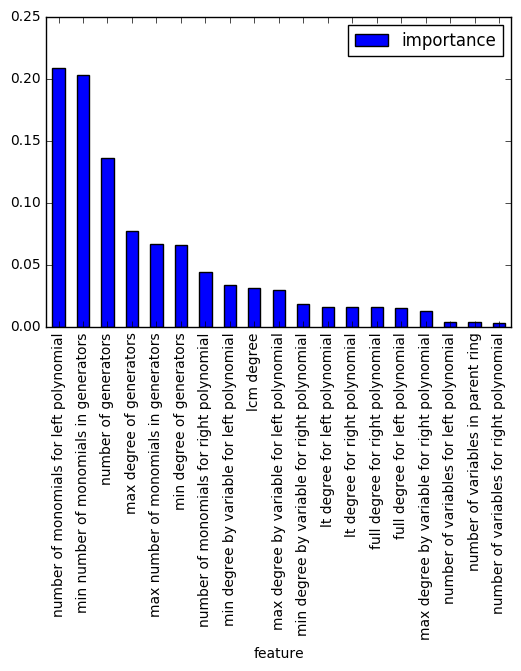

In [13]:
GetFeatureImportances(X, y_feat)

Интересно, что наиболее важными оказываются признаки идеала. А из признаков пары важнее оказываются признаки для левого полинома, чем признаки для правого.

Теперь обучим и посмотрим на соответствующие метрики для двух классификаторов: SVM и Random Forest (разделение выборки на тестовую и обучающую, а также само обучение, происходят внутри TrainAndShowMetrics).

### SVM

Classifier:

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)




accuracy = 0.952019192323 

             precision    recall  f1-score   support

 bad sPairs       0.97      0.93      0.95      1300
good sPairs       0.93      0.97      0.95      1201

avg / total       0.95      0.95      0.95      2501



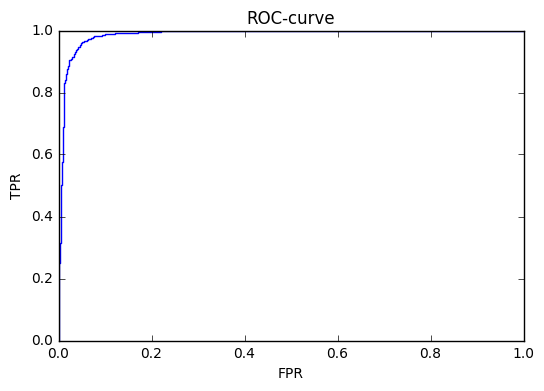

AUC-ROC: 0.98760391981


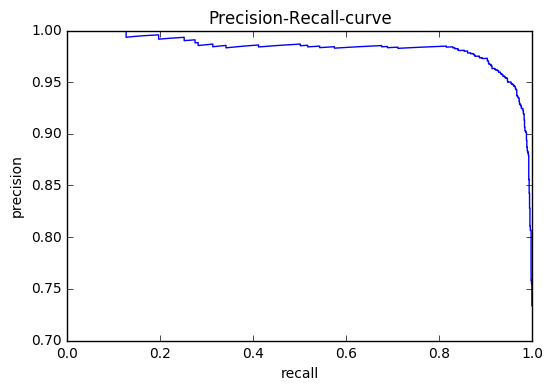

AUC-PR:  0.982438163802


In [14]:
clf = SVC(kernel = 'rbf', probability = True)

TrainAndShowMetrics(X, y_feat, 'bad sPairs', 'good sPairs', clf)

Показатели высокие. 

### Random Forest

Classifier:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)




accuracy = 0.958016793283 

             precision    recall  f1-score   support

 bad sPairs       0.97      0.95      0.96      1300
good sPairs       0.94      0.97      0.96      1201

avg / total       0.96      0.96      0.96      2501



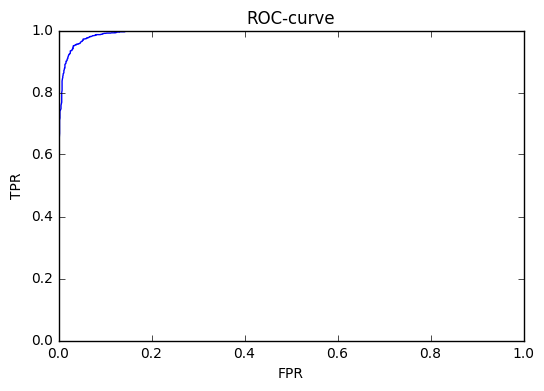

AUC-ROC: 0.993102862999


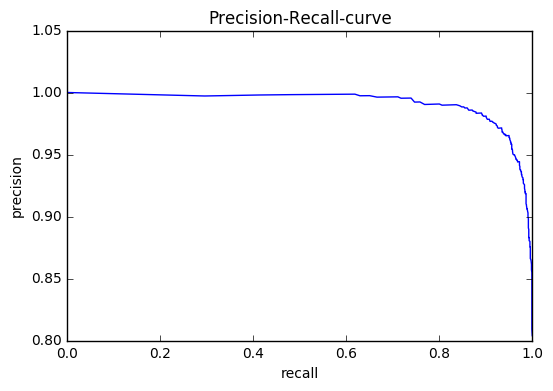

AUC-PR:  0.991704377861


In [15]:
clf = RandomForestClassifier(n_estimators = 200, n_jobs = -1, random_state = 42)

TrainAndShowMetrics(X, y_feat, 'bad sPairs', 'good sPairs', clf)

Показатели Random Forest лучше. Однако, как оказалось в дальнейшем, он жутко медленно делает предсказания, хоть и очень точно. Использовать его не получится.

#### Использование стратегии в алгоритиме

Будем выбирать S-пары, основываясь на предсказании классификатора. В функцию SelectionFunctionMachineLearning(pairs, basis, clf) передаём пары, текущий базис и классификатор. Сначала формируем признаки для каждой пары, потом формируем из них датасет и просим классификатор предсказать, нужна эта пара или нет. В соответствии с полученным вектором предсказаний берём пары (1 -- берём, 0 -- не берём). Если вдруг классификатор решил не брать ни одной пары, то проверяем, является ли текущий базис базисом Грёбнера. Если да, то останавливаемся. Если нет, то просто берём все имеющиеся пары (не выбираем из них ничего).

In [46]:
def SelectionFunctionMachineLearning(pairs, basis, clf):
    selPairs = []
    allFeatures = []
    for pair in pairs:
        featureVector = {}
        GetPairFeatures(pair, basis, featureVector)
        allFeatures.append(featureVector)

    data = MakeDataSet(allFeatures)
    pred = clf.predict(data)
    for i in range(len(pairs)):
        if pred[i] == 1:
            selPairs.append(pairs[i])
    return selPairs

def F4_ML(polynomials, strategy, clf):
    (basis, pairs) = Update([], [], polynomials)
    howManySteps = 0

    while len(pairs) > 0:
        howManySteps += 1

        if (strategy == 'normal'):
            pairsSel = SelectionFunctionNormal(pairs)
        elif (strategy == 'ML'):
            pairsSel = SelectionFunctionMachineLearning(pairs, basis, clf)
            if len(pairsSel) == 0:
                if is_groebner_basis(basis):
                    return ReductionOfBasis(basis), howManySteps
                else:
                    # print "empty set"
                    pairsSel = SelectionFunctionAll(pairs)
        else:
            pairsSel = SelectionFunctionAll(pairs)
        pairs = list(set(pairs) - set(pairsSel))

        Ld = set()
        for pair in pairsSel:
            Ld.add((pair[1], pair[2]))
            Ld.add((pair[3], pair[4]))

        new = Reduction(Ld, basis)
        (basis, pairs) = Update(basis, pairs, new)

    return ReductionOfBasis(basis), howManySteps

Запустим алгоритм с новой стратегией и с нормальной. В выводе алгоритма вторая цифра после базиса -- число итераций.

In [32]:
# clf = RandomForestClassifier(n_estimators = 200, n_jobs = -1, random_state = 42)
clf = SVC(kernel = 'rbf', probability = True)
clf.fit(X, y_feat)

print "\n\nEXAMPLE 1\n"
R.<x, y, z, u> = PolynomialRing(QQ, 4, order = "degrevlex")
F = [x + y + z, x * y + x * z + y * z, x * y * z - u ^ 3]
print "The initial system F =", F
print "\nOutput of F4:"
print "ML: ", F4_ML(F, 'ML', clf)
print "Normal: ", F4_ML(F, 'normal', clf)

print "\n\nEXAMPLE 2\n"
f = x*y - z^2 - z
g = x^2 - x - y*z
h = x*z - y^2 - y
F = [f, g, h]
print "The initial system F =", F
print "\nOutput of F4:"
print "ML: ", F4_ML(F, 'ML', clf)
print "Normal: ", F4_ML(F, 'normal', clf)

print "\n\nEXAMPLE 3\n"
R.<x1, x2, x3, x4> = PolynomialRing(QQ, 4)
F = [4*x4, -2*x2^2 - 4*x1*x3 + 6*x4^2, 4*x1^2*x2 + 4*x2*x3^2 - 4*x2^2*x4 - 8*x1*x3*x4 + 4*x4^3, -x1^4 + x2^4 - 4*x1*x2^2*x3 + 2*x1^2*x3^2 - x3^4 + 4*x1^2*x2*x4 + 4*x2*x3^2*x4 - 2*x2^2*x4^2 - 4*x1*x3*x4^2 + x4^4]
print "The initial system F =", F
print "\nOutput of F4:"
print "ML: ", F4_ML(F, 'ML', clf)
print "Normal: ", F4_ML(F, 'normal', clf)



EXAMPLE 1

The initial system F = [x + y + z, x*y + x*z + y*z, x*y*z - u^3]

Output of F4:
ML:  ([x + y + z, y^2 + y*z + z^2, z^3 - u^3], 3)
Normal:  ([x + y + z, y^2 + y*z + z^2, z^3 - u^3], 4)


EXAMPLE 2

The initial system F = [x*y - z^2 - z, x^2 - y*z - x, -y^2 + x*z - y]

Output of F4:
ML:  ([y*z, x*z - z^2 - z, y^2 - z^2 + y - z, x*y - z^2 - z, x^2 - x, z^3 + z^2], 3)
Normal:  ([y*z, x*z - z^2 - z, y^2 - z^2 + y - z, x*y - z^2 - z, x^2 - x, z^3 + z^2], 3)


EXAMPLE 3

The initial system F = [4*x4, -2*x2^2 - 4*x1*x3 + 6*x4^2, 4*x1^2*x2 + 4*x2*x3^2 - 4*x2^2*x4 - 8*x1*x3*x4 + 4*x4^3, -x1^4 + x2^4 - 4*x1*x2^2*x3 + 2*x1^2*x3^2 - x3^4 + 4*x1^2*x2*x4 + 4*x2*x3^2*x4 - 2*x2^2*x4^2 - 4*x1*x3*x4^2 + x4^4]

Output of F4:
ML:  empty set
([x4, x2^2 + 2*x1*x3, x1^2*x2 + x2*x3^2, x1^3*x3 + x1*x3^3, x1^4 - 14*x1^2*x3^2 + x3^4, x2*x3^4, x1^2*x3^3 - 1/15*x3^5, x1*x3^5, x3^7], 4)
Normal: 

 ([x4, x2^2 + 2*x1*x3, x1^2*x2 + x2*x3^2, x1^3*x3 + x1*x3^3, x1^4 - 14*x1^2*x3^2 + x3^4, x2*x3^4, x1^2*x3^3 - 1/15*x3^5, x1*x3^5, x3^7], 7)


Теперь сравним получившуюся стратегию с normal и all по числу итераций и времени.

In [17]:
def LaunchF4_iterations(n, maxVar, maxElem, maxDeg, stratOne, stratTwo, clf):
    numOfIterations = [[], []]

    for i in range (n):
        Print(n, i)
        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)
        while 0 in generators:
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)

        basis, numOfStepsNormal = F4_ML(generators, stratOne, clf)
        numOfIterations[0].append(numOfStepsNormal)

        basis, numOfStepsML = F4_ML(generators, stratTwo, clf)
        numOfIterations[1].append(numOfStepsML)

    return numOfIterations

In [18]:
def DrawDiagramForIterations(n, maxVar, maxElem, maxDeg, stratOne, stratTwo, clf):
    strategies = [stratOne, stratTwo]
    numOfIterations =  LaunchF4_iterations(n, maxVar, maxElem, maxDeg, stratOne, stratTwo, clf)
    indices = [i for i in range(n)]

    plt.figure(figsize=(12, 5))

    for i in range (2):
        plt.plot(indices, numOfIterations[i], label = '{}, sum of iterations = {}'.format(strategies[i], sum(numOfIterations[i])))

    plt.title('Iterations for {} and {} strategies'.format(stratOne, stratTwo), fontsize = 16, y = 1.02)
    plt.xlabel('Number of experiment')
    plt.ylabel('Number of iterations')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2)

Нарисуем графики с числом итераций при сравнении стратегии ML с normal и all.

Object No:  0


Object No:  10
empty set
Object No:  

20
empty set
empty set
Object No:  30


empty set


Object No:  40


empty set


Object No:  50


empty set


empty set


Object No:  60


empty set
empty set
empty set


empty set


empty set


empty set
empty set


Object No:  70


empty set


empty set


empty set


empty set


empty set


empty set


empty set


Object No:  80


Object No:  90


empty set
CPU times: user 56.7 s, sys: 303 ms, total: 57 s
Wall time: 1min 4s


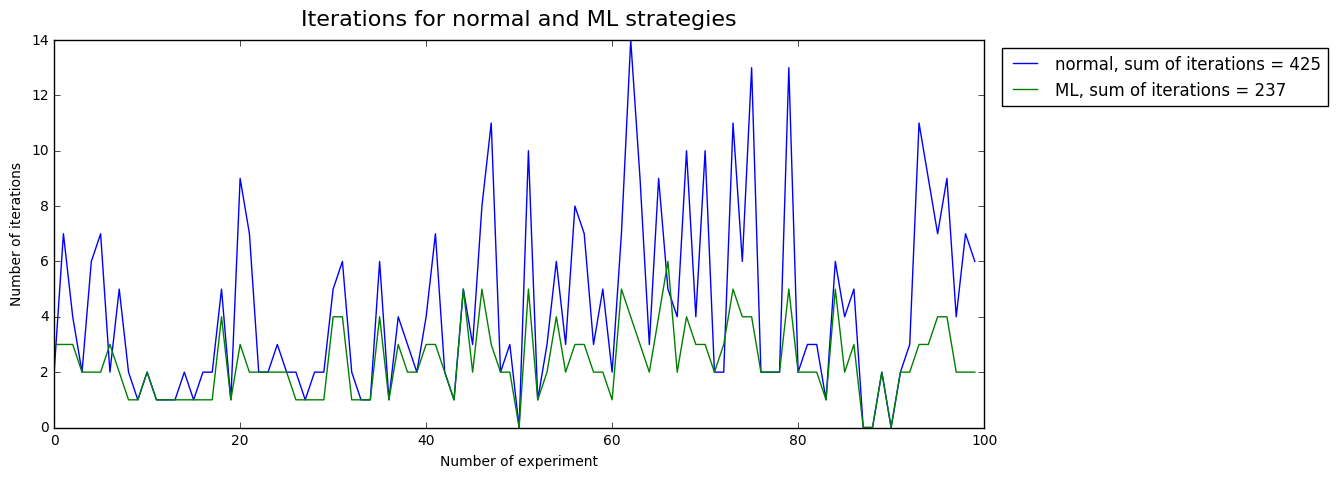

In [19]:
clf = SVC(kernel = 'rbf', probability = True)
clf.fit(X, y_feat)

%time DrawDiagramForIterations(100, 4, 5, 5, 'normal', 'ML', clf)

Видно, что Normal делает больше итераций, чем ML.

Object No:  0


empty set
Object No:  10


empty set


Object No:  20


Object No:  30


Object No:  40


empty set


empty set
Object No:  50


empty set
Object No:  60


empty set


Object No:  70
empty set


empty set


Object No:  80
empty set


empty set


Object No:  90


CPU times: user 41.8 s, sys: 207 ms, total: 42 s
Wall time: 45.9 s


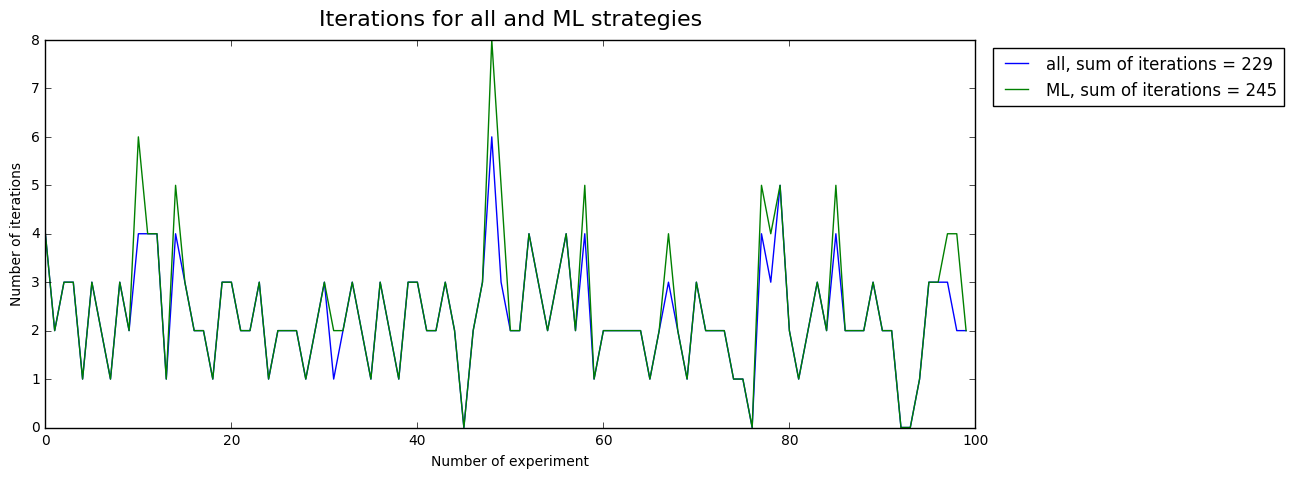

In [20]:
# clf = SVC(kernel = 'rbf', probability = True)
# clf.fit(X, y_feat)

%time DrawDiagramForIterations(100, 4, 5, 5, 'all', 'ML', clf)

А вот стратегия all побеждает ML по числу итераций.

Сравним стратегии по времени. Сначала сравним ML и normal.

In [47]:
from time import time

def PrintResultsForStrategies(times, stratOne, stratTwo):
    print "\n"
    print "Mean time:"
    print stratOne, ": ", np.mean(times[0]), ", ", stratTwo, ": ", np.mean(times[1])

    # print "\n"
    print "Max time:"
    print stratOne, ": ", max(times[0]), ", ", stratTwo, ": ", max(times[1])

    # print "\n"
    print "Min time:"
    print stratOne, ": ", min(times[0]), ", ", stratTwo, ": ", min(times[1])
    print "\n"

def LaunchF4_time_ML(n, maxVar, maxElem, maxDeg, stratOne, stratTwo, clf):
    times = [[], []]

    for i in range (n):
        Print(n, i)
        generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)
        while 0 in generators:
            generators = GetRandomGeneratorsForIdeal(maxVar, maxElem, maxDeg)

        t1 = time()
        F4_ML(generators, stratOne, clf)
        t1 = time() - t1
        times[0].append(t1)

        t2 = time()
        F4_ML(generators, stratTwo, clf)
        t2 = time() - t2
        times[1].append(t2)
    PrintResultsForStrategies(times, stratOne, stratTwo)
    return times

def DrawDiagramForTime(n, stratOne, stratTwo, times):
    strategies = [stratOne, stratTwo]
    # times =  LaunchF4_time_ML(n, maxVar, maxElem, maxDeg, stratOne, stratTwo, clf)

    indices = [i for i in range(n)]
    plt.figure(figsize=(12, 5))

    for i in range (2):
        plt.plot(indices, times[i], label = '{}'.format(strategies[i]))

    plt.title('Time for {} and {} strategies'.format(stratOne, stratTwo), fontsize = 16, y = 1.02)
    plt.xlabel('Number of experiment')
    plt.ylabel('Time')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2)

In [48]:
# clf = SVC(kernel = 'rbf', probability = True)
# clf.fit(X, y_feat)
%time times =  LaunchF4_time_ML(100, 4, 5, 5, 'normal', 'ML', clf)

Object No:  0


Object No:  10


Object No:  20


Object No:  30


Object No:  40


Object No:  50


Object No:  60


Object No:  70


Object No:  80


Object No:  90




Mean time:
normal :  0.0467098665237 ,  ML :  0.104044258595
Max time:
normal :  0.650588989258 ,  ML :  3.33159589767
Min time:
normal :  0.000128030776978 ,  ML :  9.01222229004e-05


CPU times: user 13.7 s, sys: 177 ms, total: 13.8 s
Wall time: 15.2 s


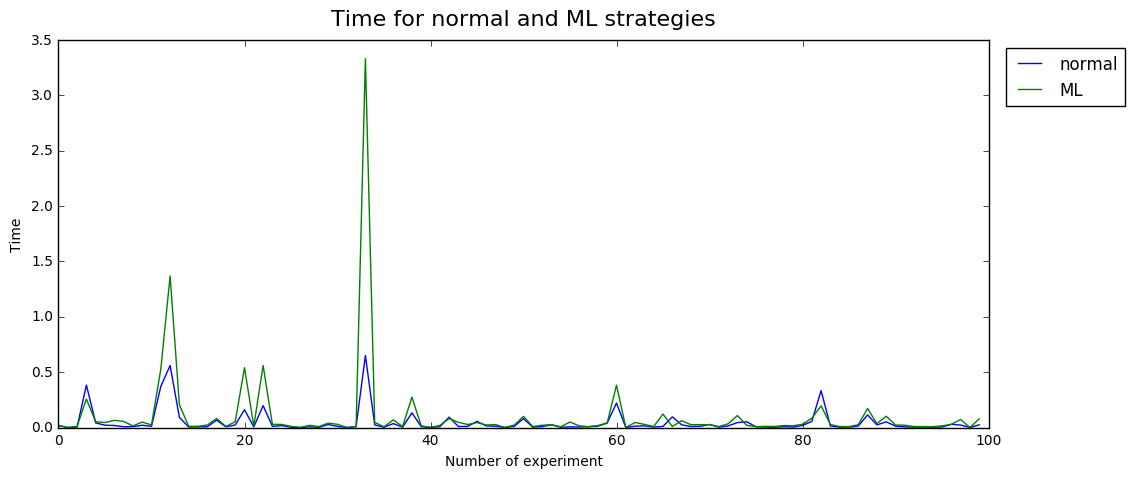

In [49]:
DrawDiagramForTime(100, 'normal', 'ML', times)

Стратегия ML проигрывает по времени normal при почти всех запусках, как видно по графику и по показателям mean time, min time, max time.

Теперь сравним по времени ML и all.

In [50]:
%time times =  LaunchF4_time_ML(100, 4, 5, 5, 'all', 'ML', clf)

Object No:  0


Object No:  10


Object No:  20


Object No:  30


Object No:  40


Object No:  50


Object No:  60


Object No:  70


Object No:  80


Object No:  90




Mean time:
all :  0.118737688065 ,  ML :  0.169333896637
Max time:
all :  5.64784789085 ,  ML :  9.09973311424
Min time:
all :  0.000171899795532 ,  ML :  0.000123977661133


CPU times: user 26.3 s, sys: 158 ms, total: 26.5 s
Wall time: 28.9 s


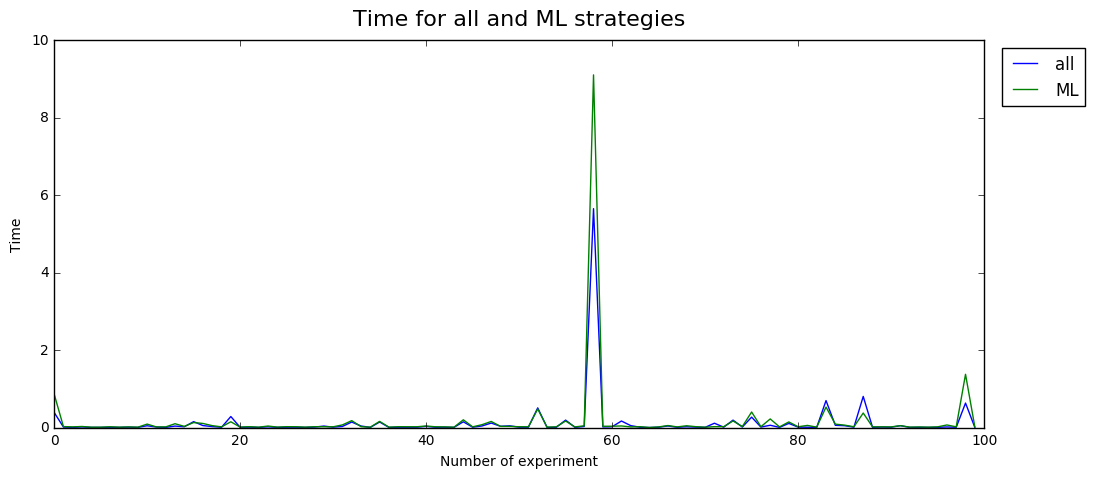

In [51]:
DrawDiagramForTime(100, 'all', 'ML', times)

Видно, что ML проигрывает стратегии all по времени.

Итак, общий итог: пока что новая стратегия выигрывают только по числу итераций у normal. По остальным параметрам пока проигрывает. Нужно думать дальше.

### Дополнение: код для кросс-валидации

In [18]:
def PrintResults(scores, scores_name):
    print "\n"
    print scores_name + " results:", scores
    print "best value: ", max(scores)
    print "mean value: ", np.mean(scores)

def CrossValidation(clf):
    print "Classifier: \n"
    print clf
    scores = cross_val_score(clf, X, y, cv = 5)
    PrintResults(scores, "accuracy")

    scoring = ['precision_macro', 'recall_macro']
    scores = cross_validate(clf, X, y, scoring=scoring, cv=5, return_train_score=False)

    PrintResults(scores['test_recall_macro'], "recall")
    PrintResults(scores['test_precision_macro'], "precision")